# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

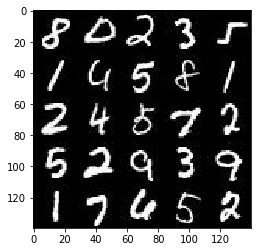

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

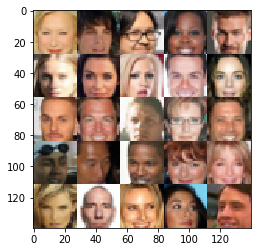

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1*alpha, x1)
        x1 = tf.layers.dropout(x1, 0.9)
        # 12x12x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2*alpha, x2)
        x2 = tf.layers.dropout(x2, 0.9)
        # 6x6x128
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3*alpha, x3)
        x3 = tf.layers.dropout(x3, 0.9)
        # 3x3x256
        # flatten layer
        flatten = tf.reshape(x3, (-1, 3*3*256))
        flatten = tf.layers.dropout(flatten, 0.9)
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        # fully_connected layer for input
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1*alpha, x1)
        x1 = tf.layers.dropout(x1, 0.5)
        # 7x7x512
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2*alpha, x2)
        x2 = tf.layers.dropout(x2, 0.5)
        # 14x14x256
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3*alpha, x3)
        x3 = tf.layers.dropout(x3, 0.5)
        # 28x28x128
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3
        out = tf.tanh(logits) * 0.5
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, alpha):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get baches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, num_channels = data_shape
    inputs_real, inputs_z, learning_rate_tensor = model_inputs(image_width, image_height, num_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, num_channels, alpha=alpha)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_tensor, beta1=beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        steps = 0
        print_every = 20
        show_every = 100
        losses = []
        samples = []
        sample_z = np.random.uniform(-1, 1, size=(10, z_dim))
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate_tensor:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate_tensor:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of 100 epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, num_channels, data_image_mode, alpha)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3722... Generator Loss: 3.6986
Epoch 1/2... Discriminator Loss: 0.3615... Generator Loss: 3.9032
Epoch 1/2... Discriminator Loss: 0.4302... Generator Loss: 6.1024
Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 5.4747
Epoch 1/2... Discriminator Loss: 1.5849... Generator Loss: 0.4851


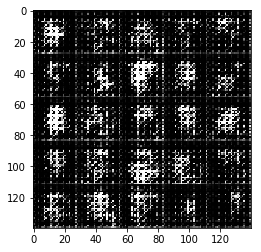

Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.6319
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 1.6472
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 1.1479


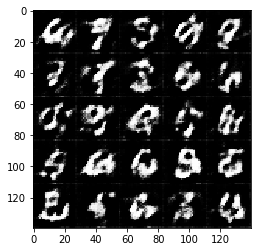

Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.2708
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 1.0152
Epoch 1/2... Discriminator Loss: 1.5133... Generator Loss: 1.9844
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 1.5937


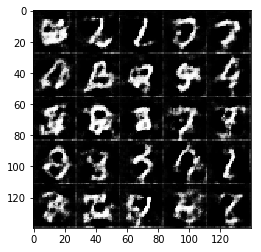

Epoch 1/2... Discriminator Loss: 1.7861... Generator Loss: 0.3205
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.0583
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.4721
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 1.0784
Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.8159


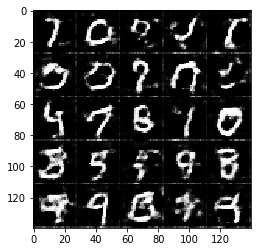

Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 2.1166
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 1.2308
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 0.7670


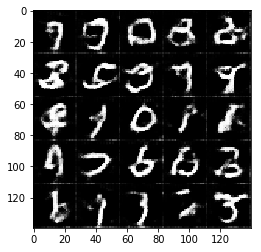

Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 1.3309
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 0.4439
Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 1.3393


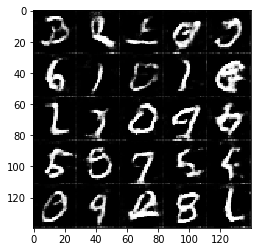

Epoch 1/2... Discriminator Loss: 1.1889... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.0442... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.5976
Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 0.6317


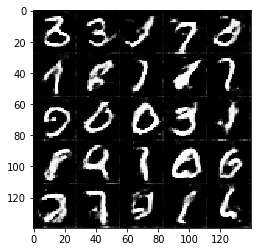

Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 0.8891
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.5945
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 1.3166
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 0.6688


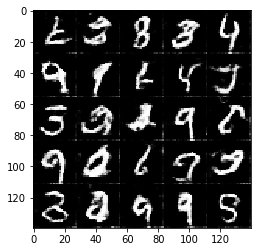

Epoch 1/2... Discriminator Loss: 1.5207... Generator Loss: 0.4270
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 0.9698
Epoch 1/2... Discriminator Loss: 1.5215... Generator Loss: 0.4714
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 1.0221
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 1.0545


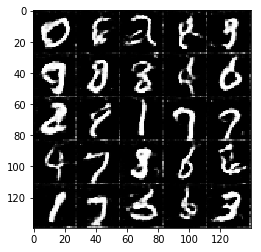

Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 1.1838
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 1.2565
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.6372


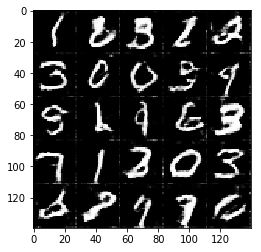

Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 0.8859
Epoch 2/2... Discriminator Loss: 1.2821... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 0.8285


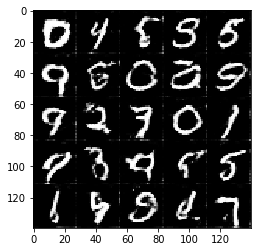

Epoch 2/2... Discriminator Loss: 1.1543... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 1.0408
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6132
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.5620


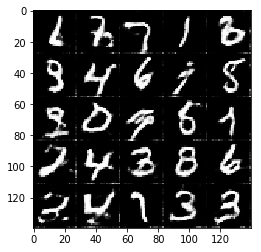

Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 1.0115
Epoch 2/2... Discriminator Loss: 1.1801... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 1.1526
Epoch 2/2... Discriminator Loss: 1.5841... Generator Loss: 0.4230
Epoch 2/2... Discriminator Loss: 0.8898... Generator Loss: 1.0559


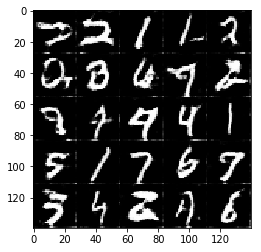

Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 1.6153
Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 1.3148
Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 1.4438
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.9502


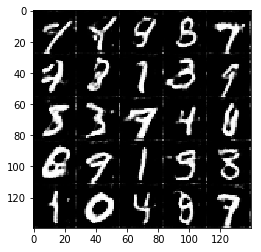

Epoch 2/2... Discriminator Loss: 1.6692... Generator Loss: 0.3777
Epoch 2/2... Discriminator Loss: 1.4864... Generator Loss: 0.5074
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 1.5449
Epoch 2/2... Discriminator Loss: 0.8282... Generator Loss: 1.4440
Epoch 2/2... Discriminator Loss: 1.6210... Generator Loss: 0.4091


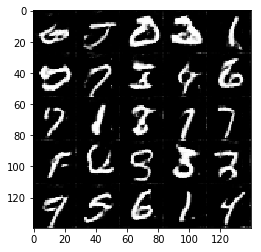

Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 0.7415
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 1.3349
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 2.4468


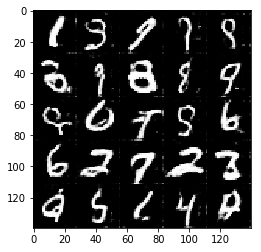

Epoch 2/2... Discriminator Loss: 0.9239... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 0.8776
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.6494
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.6606
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 1.0787


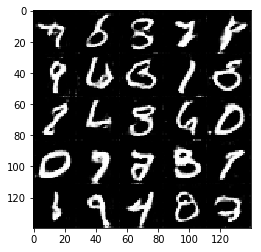

Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 1.5028
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 2.1386
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 0.5733
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 1.3915


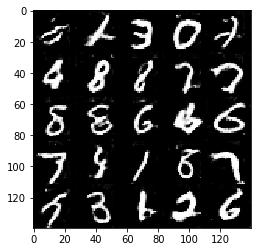

Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 1.0234
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.9543
Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 0.9697


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.5
alpha = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4367... Generator Loss: 0.1884
Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 1.1832


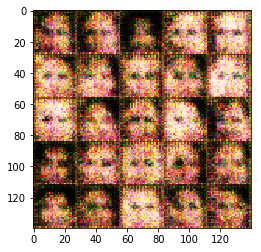

Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 0.4210


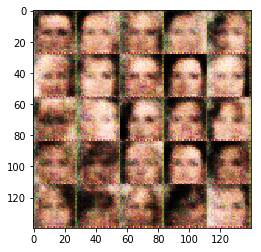

Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.0993


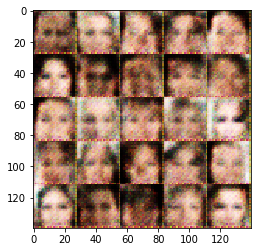

Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 3.2736
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 2.1998
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.1925


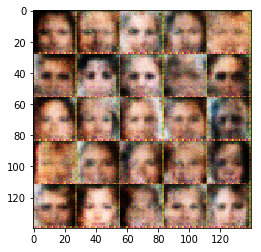

Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 1.6089
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.9890
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 2.9402
Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 0.7947


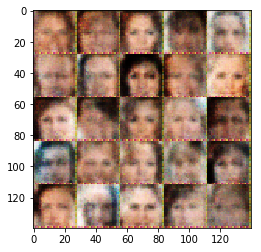

Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9576


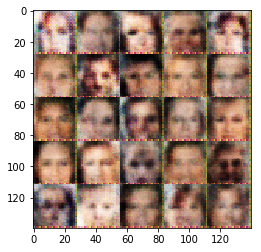

Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7869


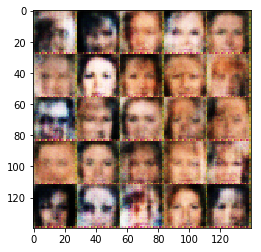

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7388


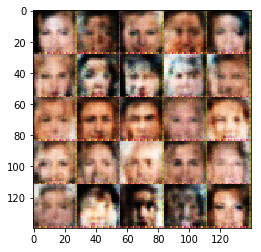

Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8294


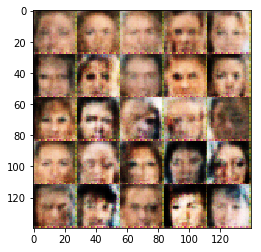

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7212


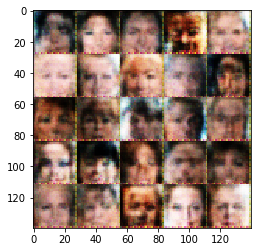

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8567


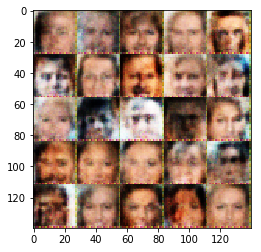

Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7386


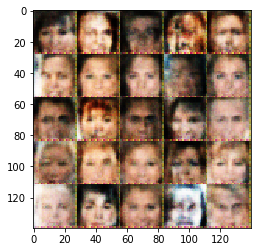

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7627


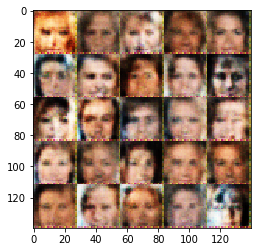

Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.8299


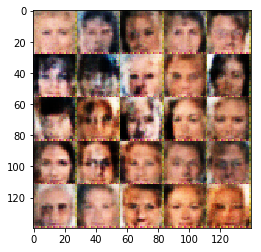

Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7865


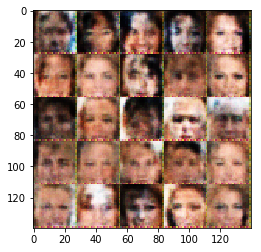

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8062


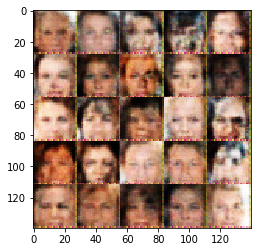

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8154


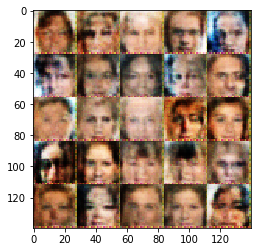

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7595


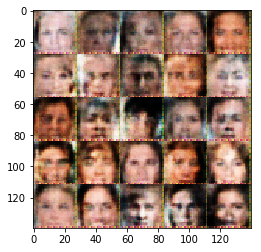

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7549


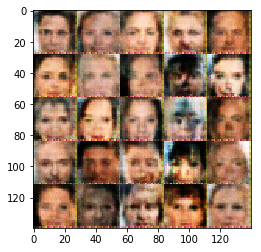

Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8360


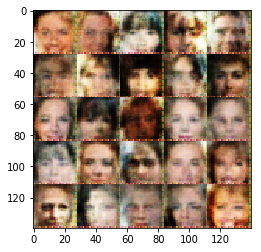

Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7356


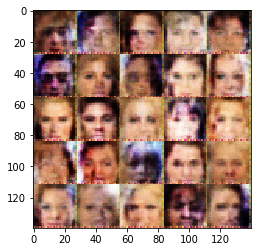

Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.8238


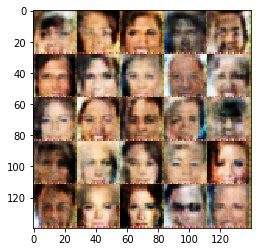

Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7902


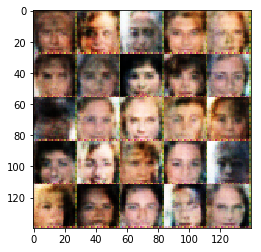

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7566


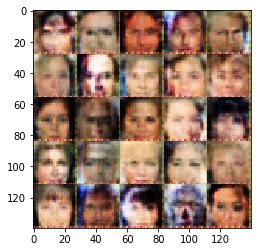

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7327


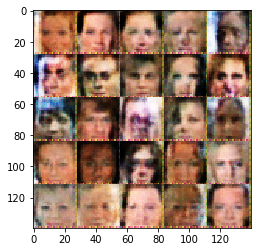

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7792


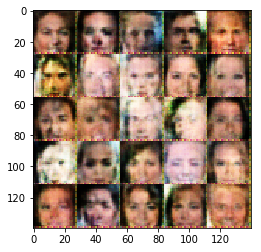

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7375


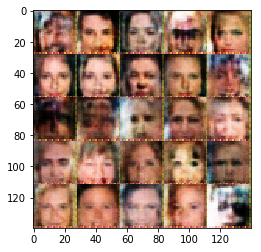

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7593


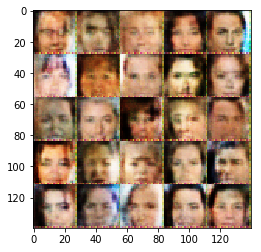

Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 1.6787... Generator Loss: 0.3539
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 2.3158


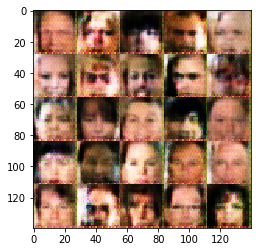

Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 3.5547
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.6377


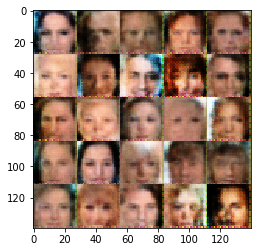

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.6036
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 1.0600
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.0475


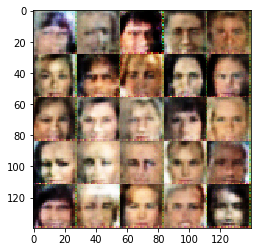

Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.3326
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 1.3469


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.